# Script to test out of sample cases and produce images of output vs input
by Andrew Rowley

In [9]:
#IMPORTS
import os

import sys
import copy
from tqdm  import tqdm

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_image

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

from dataset_3poll import NO2PredictionDataset
from transforms_3poll import ChangeBandOrder, ToTensor, DatasetStatistics, Normalize, Randomize
from model_3poll import get_model
from utils_3poll import load_data

In [10]:
os.getcwd()

'/home/mwl/Desktop/Dissertation_Code/Notebooks/RCHIVE'

In [11]:
#PARAMETERS
model_path = "/home/mwl/Desktop/Dissertation_Code/Checkpoints/ImageNet_30_epochs.model"#"checkpoints/multimodal_multioutput_fusion.model"
network = "mobilenetv3small"
map_samples_file = "/home/mwl/Desktop/Dissertation_Code/Data/data/editted/samples_multimodal_3polls.csv"#samples_multimodal_3polls.csv #"data/samples_S2S5P_whole_timespan.csv"
datadir = "/home/mwl/Desktop/Dissertation_Code/Datadir/eea"
result_dir = "results/MultiModalResults"
# sources = "S2S5P"
# frequency = "2018_2020"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 15

In [12]:
#LOAD STUDY DATA
datastats = DatasetStatistics() 
tf = transforms.Compose([ChangeBandOrder(), Normalize(datastats), ToTensor()])
# tf = transforms.Compose([ChangeBandOrder(), Randomize(), ToTensor()])

samples_map, stations = load_data(datadir, map_samples_file) 
dataset_map = NO2PredictionDataset(datadir, samples_map, transforms=tf, station_imgs=stations) 
dataloader_map = DataLoader(dataset_map, batch_size=1, num_workers=0, shuffle=False, pin_memory=False)

Available columns from samples_file :
Index(['AirQualityStation', 'img_path', 's5p_path', 'Countrycode', 'Altitude',
       'PopulationDensity', 'rural', 'suburban', 'urban', 'traffic',
       'industrial', 'background', 'no2', 'o3', 'pm10'],
      dtype='object')


100%|██████████████████████████████████████| 1317/1317 [00:12<00:00, 109.30it/s]


In [13]:
#READ IN MODEL
model = get_model(device, network,True,True,model_path)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

RegressionHead_1(
  (backbone_S2): MobileNetV3(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): ConvNormAc

In [14]:
#DEFINE MODEL RUNNING FUNCTION
def run_model(model, dataloader, device):
    model.eval()

    measurements_no2 =[]
    measurements_o3 =[]
    measurements_pm10 =[]

    predictions_no2 =[]
    predictions_o3 =[]
    predictions_pm10 =[]

    with torch.no_grad():
        for idx, sample in enumerate(dataloader):
            img = sample["img"].float().to(device)
            s5p = sample["s5p"].float().unsqueeze(dim=1).to(device)

            Onehot1 = sample["rural"]
            Onehot2 = sample["suburban"]
            Onehot3 = sample["urban"]
            Onehot4 = sample["traffic"]
            Onehot5 = sample["industrial"]
            Onehot6 = sample["background"]
            tabular = [sample["Altitude"], sample["PopulationDensity"], Onehot1, Onehot2, Onehot3, Onehot4, Onehot5,Onehot6]
            tabular = torch.stack(tabular,dim=1).float().to(device)
            model_input = {"img": img, "s5p": s5p, "tabular": tabular}

            y_hat_1,y_hat_2,y_hat_3 = model(model_input)
            y_hat_no2 = y_hat_1.squeeze()
            y_hat_o3 = y_hat_2.squeeze()
            y_hat_pm10 = y_hat_3.squeeze()

            y_no2 = sample["no2"].float().to(device).squeeze()
            y_o3 = sample["o3"].float().to(device).squeeze()
            y_pm10 = sample["pm10"].float().to(device).squeeze()

            measurements_no2.append(y_no2.cpu().numpy().item())
            measurements_o3.append(y_o3.cpu().numpy().item())
            measurements_pm10.append(y_pm10.cpu().numpy().item())

            predictions_no2.append(y_hat_no2.cpu().numpy().item())
            predictions_o3.append(y_hat_o3.cpu().numpy().item())
            predictions_pm10.append(y_hat_pm10.cpu().numpy().item())

    measurements_no2 = Normalize.undo_no2_standardization(datastats, np.array(measurements_no2))
    measurements_o3 = Normalize.undo_o3_standardization(datastats, np.array(measurements_o3))
    measurements_pm10 = Normalize.undo_pm10_standardization(datastats, np.array(measurements_pm10))

    predictions_no2 = Normalize.undo_no2_standardization(datastats, np.array(predictions_no2))
    predictions_o3 = Normalize.undo_o3_standardization(datastats, np.array(predictions_o3))
    predictions_pm10 = Normalize.undo_pm10_standardization(datastats, np.array(predictions_pm10))

    measurements = {"no2":measurements_no2,
                    "o3":measurements_o3,
                    "pm10":measurements_pm10}
    predictions = {"no2":predictions_no2,
                    "o3":predictions_o3,
                    "pm10":predictions_pm10}
            
    return measurements, predictions

In [15]:
#CREATE PREDICTIONS
map_y, map_y_hat = run_model(model, dataloader_map, device)

In [16]:
#alts

In [17]:
map_y

{'no2': array([ 8.08637955, 25.74856667, 20.13982853, ...,  5.61913662,
        23.72430623, 25.55343031]),
 'o3': array([55.92163617, 43.68184595, 48.83727072, ..., 55.59463411,
        49.79903801, 46.78721334]),
 'pm10': array([ 8.4373571 , 29.2333487 , 21.18092627, ..., 10.83333304,
        19.28046254, 22.22160943])}

In [18]:
map_y_hat

{'no2': array([ 8.02499384, 25.47911325, 20.37355708, ...,  9.88306883,
        24.38932523, 31.01170366]),
 'o3': array([69.40612426, 49.30558079, 51.2468942 , ..., 64.17055552,
        46.65801937, 44.7314959 ]),
 'pm10': array([13.47896406, 24.7461456 , 22.62622725, ..., 16.19788433,
        26.77989643, 28.88650259])}

In [19]:
def test_plotter(test_y, test_y_hat):
    # create plot
    img, axs = plt.subplots(1, 3, figsize=(12, 12))
    img.subplots_adjust(hspace=0.25)
    img.subplots_adjust(wspace=0.25)

    no2_lim = 80
    o3_lim = 120
    pm10_lim = 80

    #long winded plotting
    #no2
    axs[0].scatter(test_y["no2"], test_y_hat["no2"], s=10, c="#C00000")
    axs[0].set_title("NO2 fit quality")
    axs[0].set_xlabel("Measurements")
    axs[0].set_ylabel("Predictions")
    axs[0].set_xlim((0, no2_lim))
    axs[0].set_ylim((0, no2_lim))
    axs[0].set_aspect('equal')
    axs[0].axline((0, 0), slope=1, c ="red")
    #o3
    axs[1].scatter(test_y["o3"], test_y_hat["o3"], s=10, c="#70AD47")
    axs[1].set_title("O3 fit quality")
    axs[1].set_xlabel("Measurements")
    axs[1].set_ylabel("Predictions")
    axs[1].set_xlim((0, o3_lim))
    axs[1].set_ylim((0, o3_lim))
    axs[1].set_aspect('equal')
    axs[1].axline((0, 0), slope=1, c ="red")
    #pm10
    axs[2].scatter(test_y["pm10"], test_y_hat["pm10"], s=10, c="#44546A")
    axs[2].set_title("PM10 fit quality")
    axs[2].set_xlabel("Measurements")
    axs[2].set_ylabel("Predictions")
    axs[2].set_xlim((0, pm10_lim))
    axs[2].set_ylim((0, pm10_lim))
    axs[2].set_aspect('equal')
    axs[2].axline((0, 0), slope=1, c ="red")

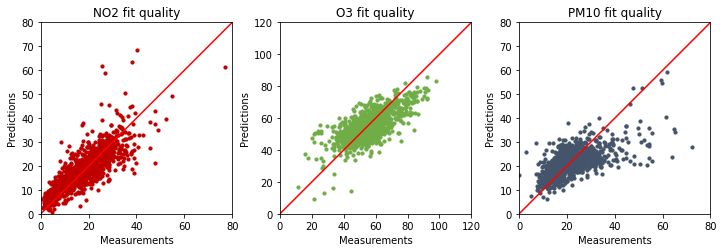

In [20]:
test_plotter(map_y, map_y_hat)

In [21]:
#DEFINE FUNCTION FOR CREATING DICTIONARY OF INPUTS AND OUTPUTS
def model_inspector(index,dataset,dataloader,model,device):
    img = dataset[index].get("img")
    s5p = dataset[index].get("s5p")
    areatype = dataset[index].get("AreaType")
    stationtype = dataset[index].get("StationType")
    airqualitystation = dataset[index].get("AirQualityStation")
    location = dataset[index].get("Location")
    region = dataset[index].get("Region")
    alpha = dataset[index].get("Alpha") 
    alpha = dataset[index].get("Tabular") 
    alt = dataset[index].get("Altitude") 
    popdense = dataset[index].get("PopulationDensity") 
    
    #altitude values
    alt_mean = 246.9503722
    alt_std = 255.961989

    #popdense values
    popdense_mean = 435.719603
    popdense_std = 1049.972678    
    
    #alt = alt*alt_std+alt_mean
    #popdense = popdense*popdense_std+popdense_mean
    
    y, y_hat = run_model(model, dataloader, device)
    
    y_no2 = y["no2"]
    y_o3 = y["o3"]
    y_pm10 = y["pm10"]
    
    y_no2_hat = y_hat["no2"]
    y_o3_hat = y_hat["o3"]
    y_pm10_hat = y_hat["pm10"]
    
    d = {"idx":index,"img":img,"s5p": s5p,"areatype":areatype,
         "no2_true":y_no2[index],"no2_pred":y_no2_hat[index],
         "o3_true":y_o3[index],"o3_pred":y_o3_hat[index],
         "pm10_true":y_pm10[index],"pm10_pred":y_pm10_hat[index],
         "location":location,"airqualitystation":airqualitystation,
         "alpha":alpha,"region":region,"stationtype":stationtype,
         "alt":alt,"popdense":popdense
        }
    
    return d

In [22]:
def alpha(no2,o3,pm10): 
    #air quality index calculation
    alpha = 1 - (1/3)*( (10-no2)/10  + (60-o3)/60 + (15-pm10)/15 )   
    return alpha

In [23]:
also = pd.read_csv(map_samples_file)
also.head()

idx AirQualityStation                                           img_path  \
0    2       STA.IT1863A  STA.IT1863A/S2A_MSIL2A_20200123T095311_N0213_R...   
1    3       STA-BETR701  STA-BETR701/S2A_MSIL2A_20200530T105031_N0214_R...   
2    4       STA-FR16029  STA-FR16029/S2B_MSIL2A_20200807T102559_N0214_R...   
3    9       STA.IT0963A  STA.IT0963A/S2B_MSIL2A_20200821T100559_N0214_R...   
4   11       STA_ES0009R  STA_ES0009R/S2A_MSIL2A_20200824T110631_N0214_R...   

                                            s5p_path Countrycode  Altitude  \
0  STA.IT1863A/l3_mean_europe_2018_2020_005dg.netcdf          IT     954.0   
1  STA-BETR701/l3_mean_europe_2018_2020_005dg.netcdf          BE       5.0   
2  STA-FR16029/l3_mean_europe_2018_2020_005dg.netcdf          FR     114.0   
3  STA.IT0963A/l3_mean_europe_2018_2020_005dg.netcdf          IT       1.0   
4  STA_ES0009R/l3_mean_europe_2018_2020_005dg.netcdf          ES    1360.0   

   PopulationDensity  rural  suburban  urban  traffic  industrial  background  \
0               55.3      1         0      0        0           0           1   
1              594.5      0         0      1        0           0           1   
2              237.6      0         0      1        0           0           1   
3              442.4      0         0      1        0           0           1   
4               21.2      1         0      0        0           0           1   

         no2         o3       pm10  
0   8.086380  55.921636   8.437357  
1  25.748567  43.681846  29.233349  
2  20.139829  48.837270  21.180926  
3  28.427060  55.848528  29.574176  
4   1.701444  73.604106   8.334294

In [24]:
#A FUNCTION TO VIEW EACH RESULTS PACK
def prediction_viewer(results, also):  
    
    #band data
    band_data = results.get("img")
    band_data = reshape_as_image(np.array(band_data))
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))
    data2 = (band_data - lower_perc) / (upper_perc - lower_perc)
    
    #plot
    fig, axs = plt.subplots(1, 2, figsize=(7,7))
    fig.patch.set_linewidth(7)
    fig.patch.set_edgecolor('black')
    s2_ax = axs[0]
    s2_ax.imshow(data2[:, :, [3,2,1]]) 
    s2_ax.set_title("Sentinel2 data")
    im = axs[1].imshow(results.get("s5p"))
    axs[1].set_title("Sentinel-5P data")
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.3]) #left bottom width height
    fig.colorbar(im, cax=cbar_ax)
    
    #title
    fig.text(0, 0.95, results["airqualitystation"] , fontsize = 22, bbox = dict(facecolor = 'blue', alpha = 0.5))
    fig.text(0, 0.88, results["location"] , fontsize = 16, bbox = dict(facecolor = 'lightblue', alpha = 0.5))
    fig.text(0, 0.82, results["region"] , fontsize = 16, bbox = dict(facecolor = 'lightblue', alpha = 0.5))

    #tabular
    alt = also["Altitude"]
    popdense = also["PopulationDensity"]
    areatype = results["areatype"]
    stationtype = results["stationtype"]
    fig.text(0.66, 0.9, 'Altitude: '+str("{:.0f}".format(alt)) , fontsize = 16, bbox = dict(facecolor = 'violet', alpha = 0.5))
    fig.text(0.66, 0.85, 'Pop.Density: '+str("{:.0f}".format(popdense)) , fontsize = 16, bbox = dict(facecolor = 'violet', alpha = 0.5))
    fig.text(0.66, 0.8, areatype , fontsize = 16, bbox = dict(facecolor = 'lightgreen', alpha = 0.5))
    fig.text(0.66, 0.75, stationtype , fontsize = 16, bbox = dict(facecolor = 'lightgreen', alpha = 0.5))
   
    #predictions
    no2_true = results["no2_true"]
    no2_pred = results["no2_pred"]
    o3_true = results["o3_true"]
    o3_pred = results["o3_pred"]
    pm10_true = results["pm10_true"]
    pm10_pred = results["pm10_pred"]
    text_bbox = dict(facecolor = 'red', alpha = 0.5)
    
    #text
    fig.text(0, 0.25, 'Measured NO2: '+str("{:.2f}".format(no2_true)), fontsize = 10, bbox = text_bbox)
    fig.text(0, 0.2, 'Predicted NO2: '+str("{:.2f}".format(no2_pred)), fontsize = 10, bbox = text_bbox)
    fig.text(0.33, 0.25, 'Measured O3: '+str("{:.2f}".format(o3_true)), fontsize = 10, bbox = text_bbox)
    fig.text(0.33, 0.2, 'Predicted O3: '+str("{:.2f}".format(o3_pred)), fontsize = 10, bbox = text_bbox)
    fig.text(0.66, 0.25, 'Measured PM10: '+str("{:.2f}".format(pm10_true)), fontsize = 10, bbox = text_bbox)
    fig.text(0.66, 0.2, 'Predicted PM10: '+str("{:.2f}".format(pm10_pred)), fontsize = 10, bbox = text_bbox)

    #alpha
    alpha_true = alpha(no2_true,o3_true,pm10_true)
    alpha_pred = alpha(no2_pred,o3_pred,pm10_pred)
    diff = alpha_pred - alpha_true
    fig.text(0.66, 0.14, 'Measured Alpha: '+str("{:.2f}".format(alpha_true)), fontsize = 16, bbox = dict(facecolor = 'yellow', alpha = 0.5))
    fig.text(0.66, 0.09, 'Predicted Alpha: '+str("{:.2f}".format(alpha_pred)), fontsize = 16, bbox = dict(facecolor = 'yellow', alpha = 0.5))
    fig.text(0.66, 0.04, 'Difference: '+str("{:.2f}".format(diff)), fontsize = 16, bbox = dict(facecolor = 'pink', alpha = 0.5))

    #present
    fig.show()

In [25]:
import warnings
import logging

In [26]:
#print the results
results = []
for i in tqdm(range(0,35),unit="station"):
    results.append(model_inspector(i,dataset_map,dataloader_map,model,device))
print(results)

100%|██████████████████████████████████████| 35/35 [05:20<00:00,  9.15s/station]

[{'idx': 0, 'img': tensor([[[-0.5890, -0.5836, -0.5709,  ..., -0.4862, -0.5043, -0.5241],
         [-0.5746, -0.5673, -0.5529,  ..., -0.4826, -0.5007, -0.5169],
         [-0.5619, -0.5511, -0.5331,  ..., -0.4808, -0.4952, -0.5097],
         ...,
         [-0.3709, -0.3781, -0.3817,  ..., -0.5727, -0.5727, -0.5727],
         [-0.3871, -0.3943, -0.3961,  ..., -0.5962, -0.5962, -0.5980],
         [-0.3889, -0.3961, -0.3997,  ..., -0.6070, -0.6088, -0.6088]],

        [[-0.7301, -0.7371, -0.7406,  ..., -0.0995, -0.2305, -0.5939],
         [-0.7459, -0.7494, -0.7371,  ..., -0.2969, -0.5153, -0.7197],
         [-0.6323, -0.6830, -0.6830,  ..., -0.3615, -0.6498, -0.4349],
         ...,
         [-0.5310, -0.5135, -0.5467,  ..., -0.7459, -0.7494, -0.7494],
         [-0.5170, -0.4978, -0.5205,  ..., -0.7494, -0.7476, -0.7494],
         [-0.4349, -0.4314, -0.4017,  ..., -0.7494, -0.7494, -0.7424]],

        [[-0.7570, -0.8616, -0.8582,  ..., -0.1102, -0.3967, -0.6815],
         [-0.7570, -0.8753

In [27]:
results[0].keys()

dict_keys(['idx', 'img', 's5p', 'areatype', 'no2_true', 'no2_pred', 'o3_true', 'o3_pred', 'pm10_true', 'pm10_pred', 'location', 'airqualitystation', 'alpha', 'region', 'stationtype', 'alt', 'popdense'])

In [28]:
# "airqualitystation","location","region","no2_true","no2_pred","o3_true","o3_pred","pm10_true","pm10_pred",alpha_true,alpha_pre

In [29]:
#pull metrics out of result dict
results_list = []
for i in range(0,35):
    x = results[i]
    alpha_true = alpha(x["no2_true"],x["o3_true"],x["pm10_true"])
    alpha_pred = alpha(x["no2_pred"],x["o3_pred"],x["pm10_pred"])
    dummy_list = [x["airqualitystation"],x["location"],x["region"],x["no2_true"],
                  x["no2_pred"],x["o3_true"],x["o3_pred"],x["pm10_true"],x["pm10_pred"],alpha_true,alpha_pred]
    results_list.append(dummy_list)
pred_table = pd.DataFrame(results_list,columns=["airqualitystation","location","region","no2_true","no2_pred","o3_true","o3_pred","pm10_true","pm10_pred","alpha_true","alpha_pred"])
pred_table.head()

airqualitystation location region   no2_true   no2_pred    o3_true  \
0       STA.IT1863A     None   None   8.086380   8.024994  55.921636   
1       STA-BETR701     None   None  25.748567  25.479113  43.681846   
2       STA-FR16029     None   None  20.139829  20.373557  48.837271   
3       STA.IT0963A     None   None  28.427060  26.874712  55.848528   
4       STA_ES0009R     None   None   1.701443   3.690631  73.604106   

     o3_pred  pm10_true  pm10_pred  alpha_true  alpha_pred  
0  69.406124   8.437357  13.478964    0.767719    0.952622  
1  49.305581  29.233349  24.746146    1.750592    1.673138  
2  51.246894  21.180926  22.626227    1.413333    1.466629  
3  48.338865  29.574176  25.746370    1.915042    1.736515  
4  78.026588   8.334294   9.533022    0.650833    0.768347

In [32]:
#print the prediction table
pred_table.to_csv(r"/home/mwl/Desktop/Dissertation_Code/Notebooks/RCHIVE/results/MultiModalResults/3_pollutants/_OutOfSampleTesting/OOS_predictions.csv")

 56%|█████████████████████                 | 20/36 [03:02<02:27,  9.20s/station]/home/mwl/anaconda3/envs/ailab/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
100%|██████████████████████████████████████| 36/36 [05:29<00:00,  9.15s/station]


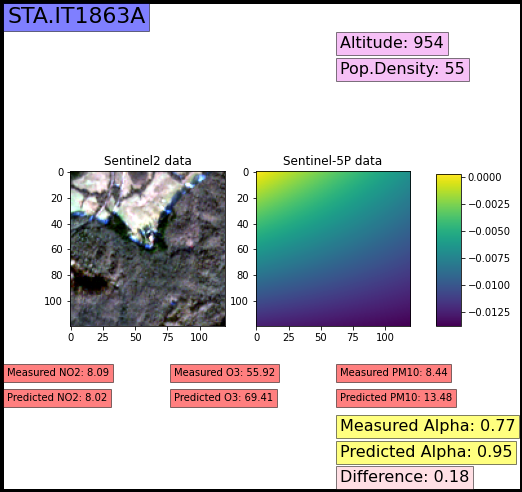

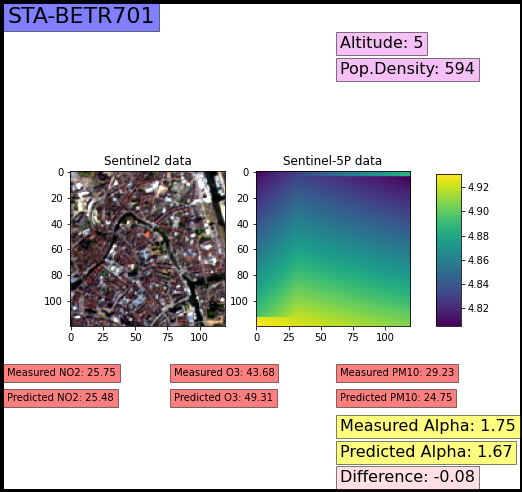

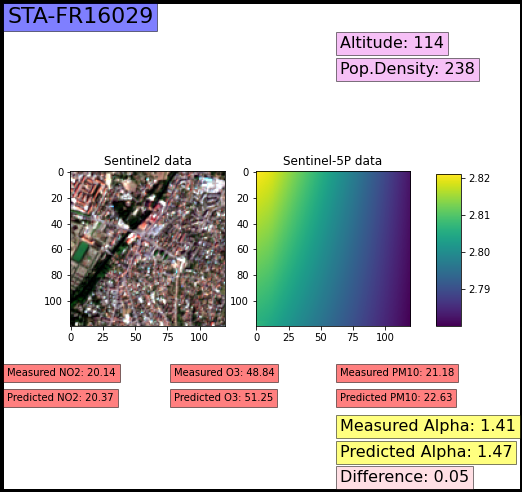

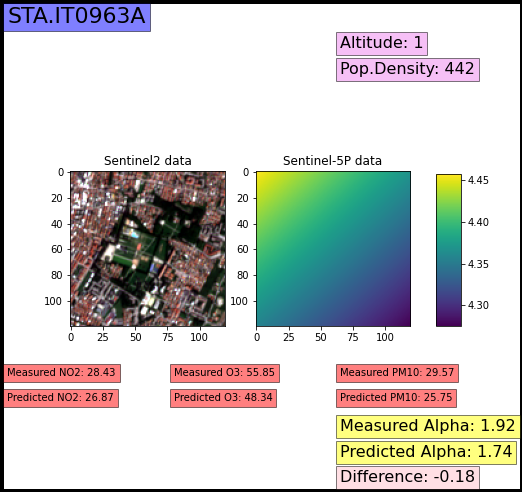

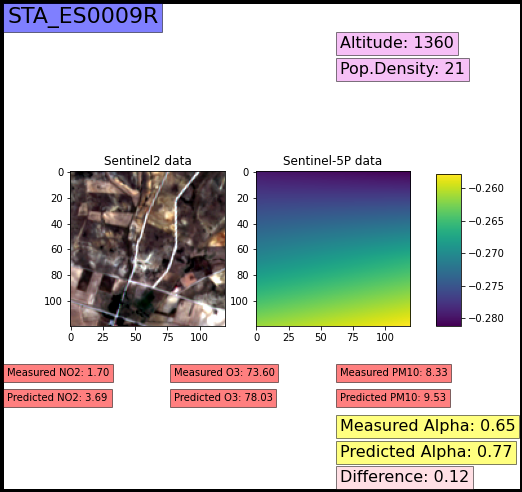

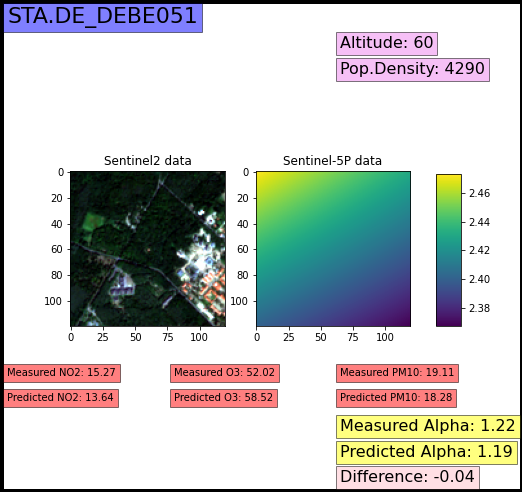

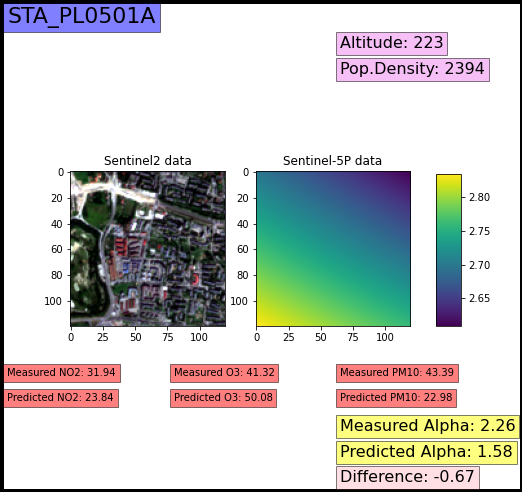

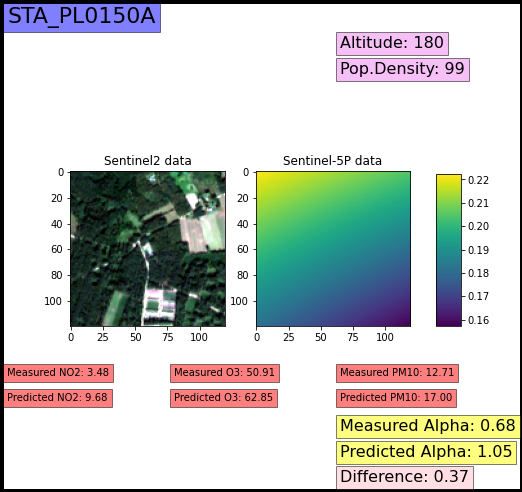

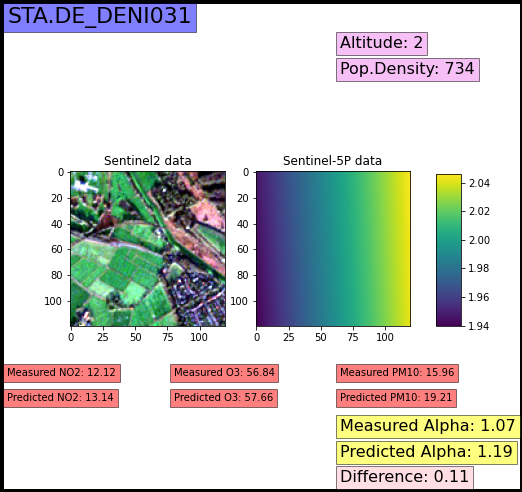

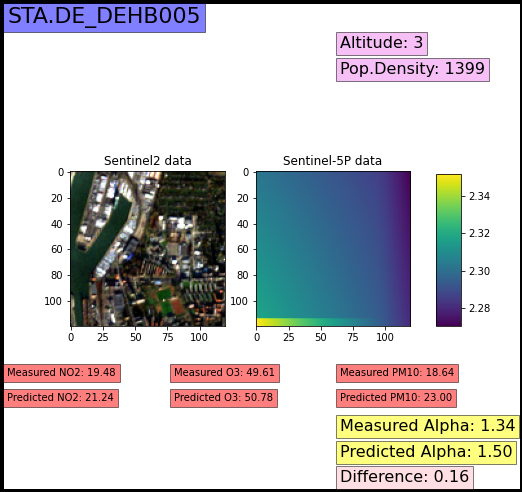

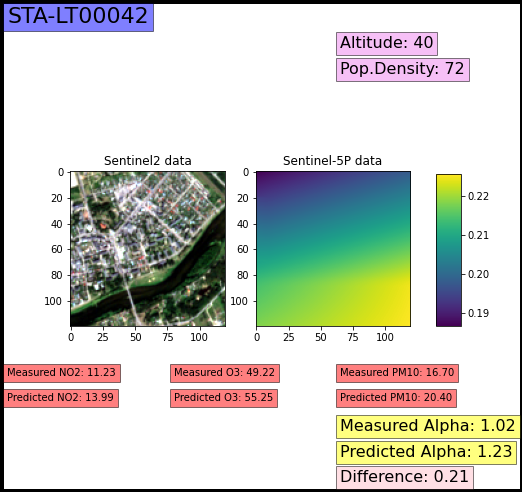

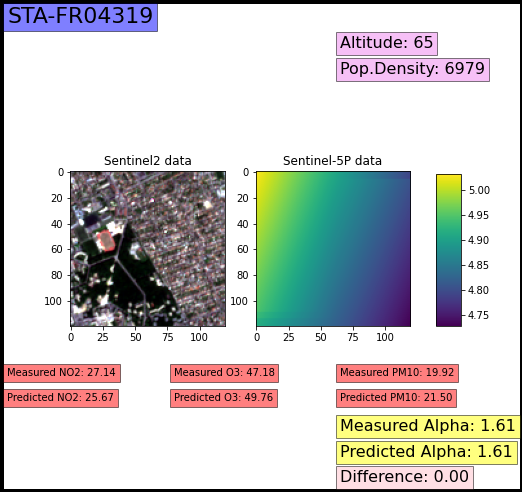

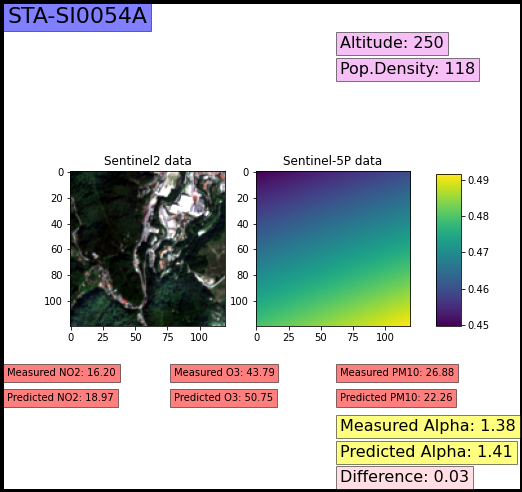

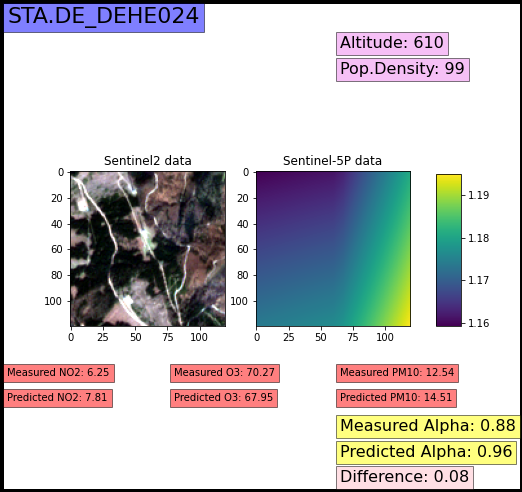

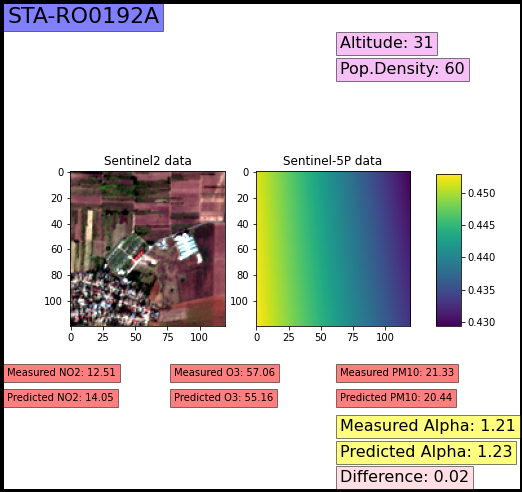

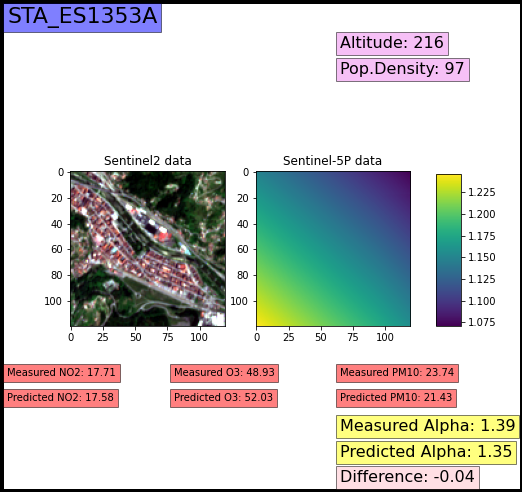

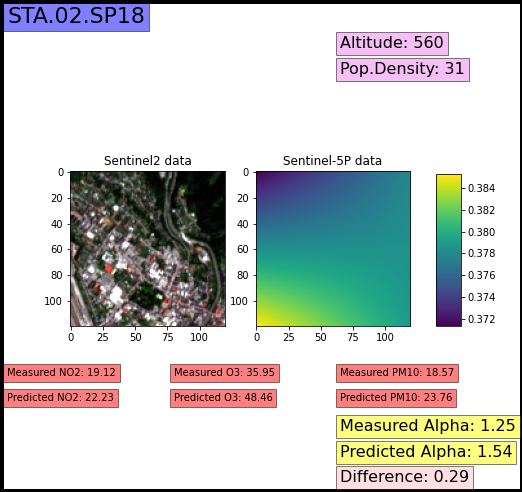

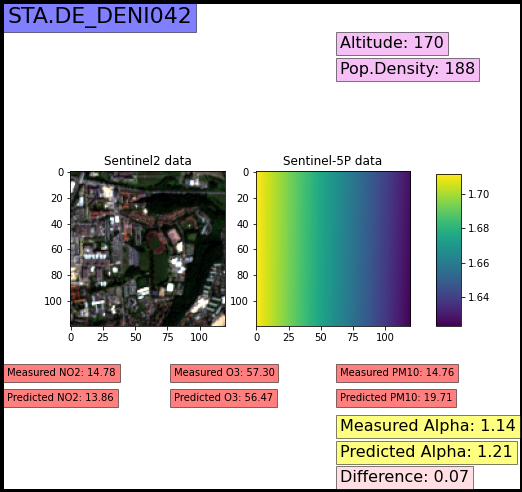

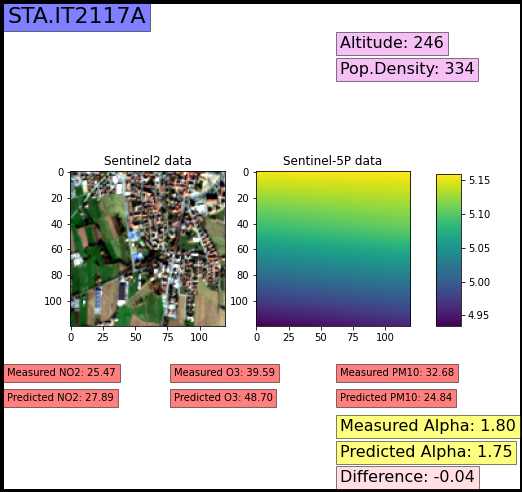

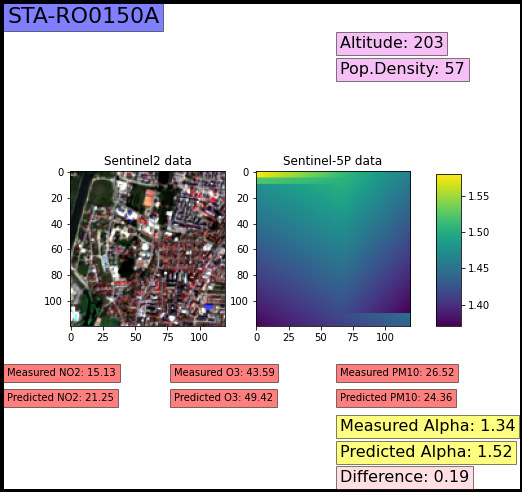

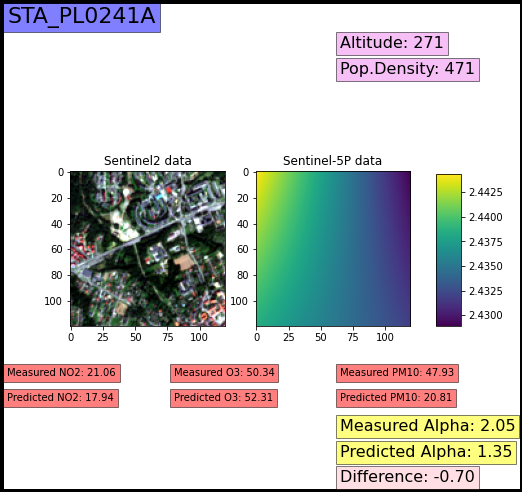

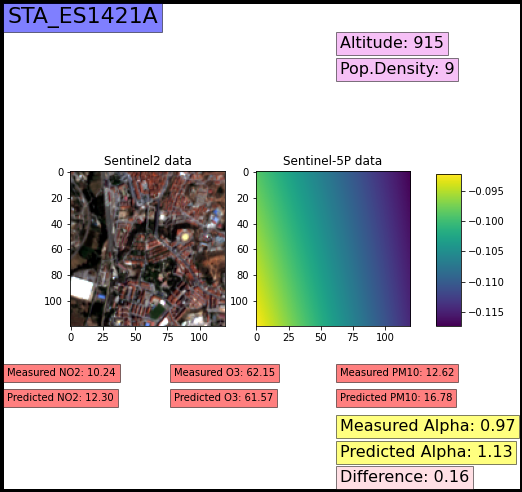

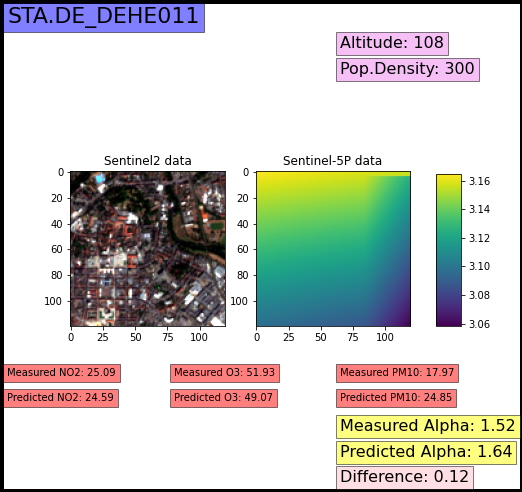

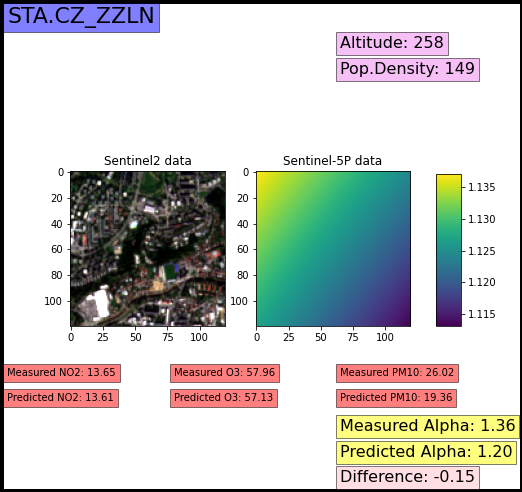

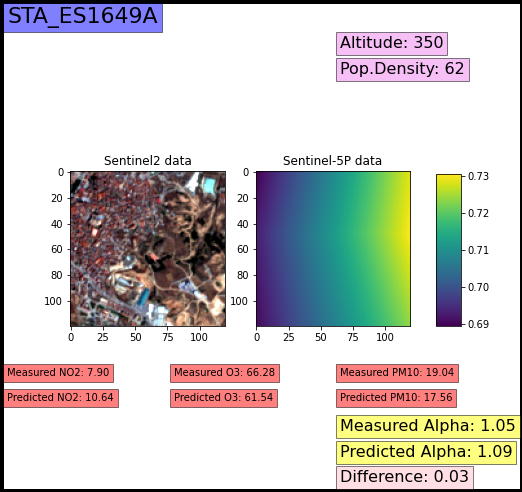

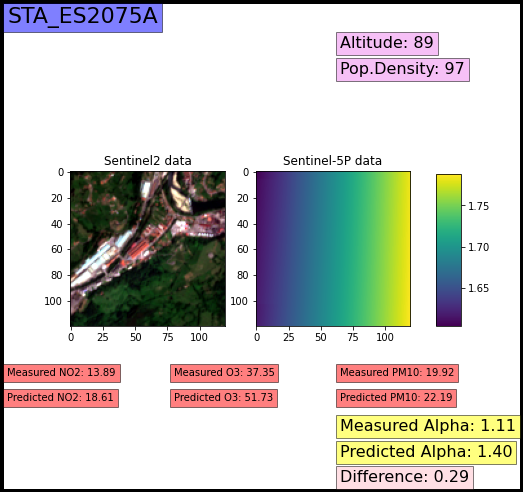

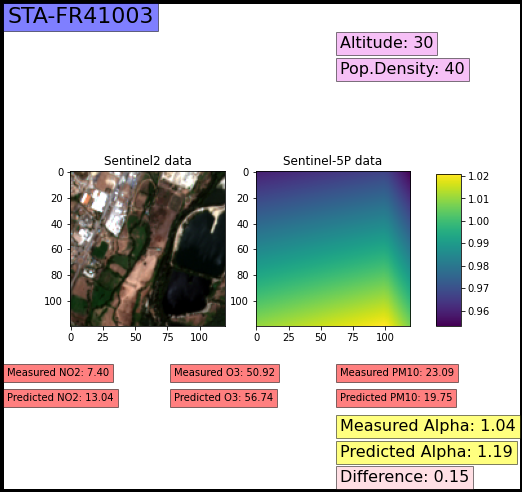

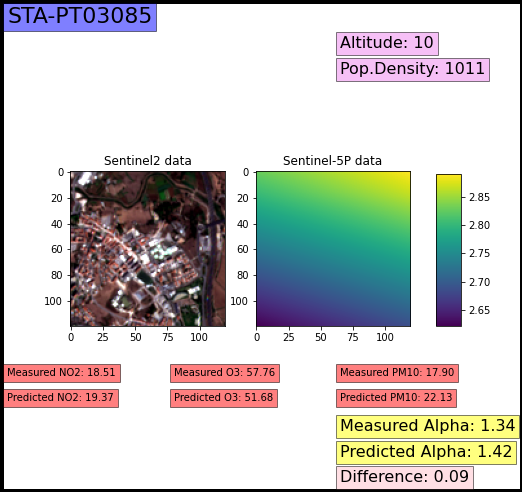

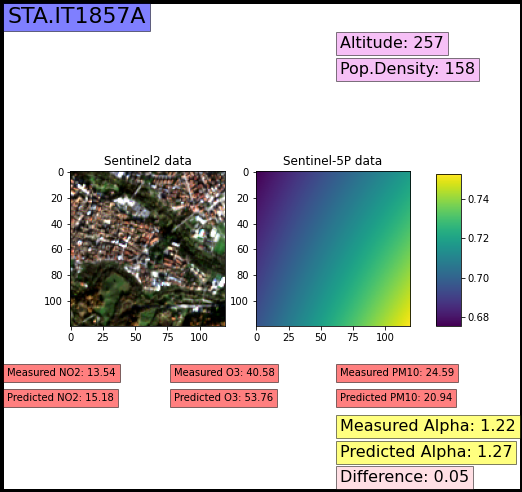

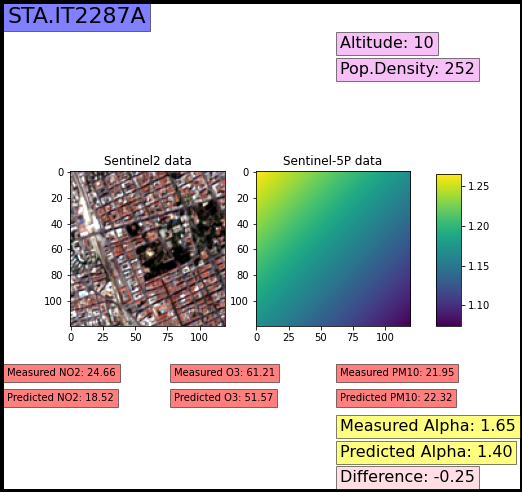

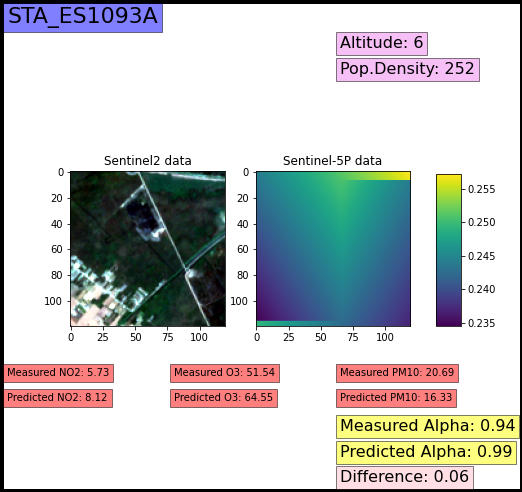

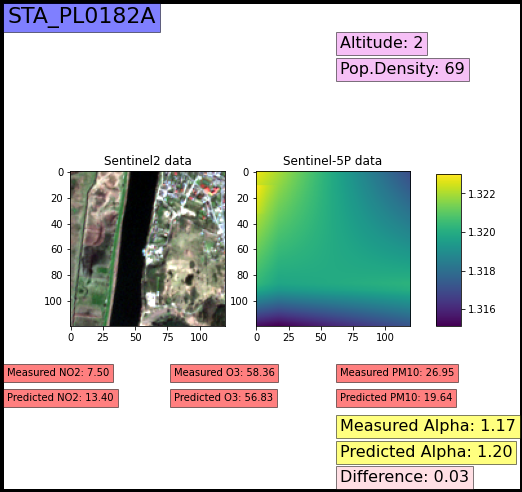

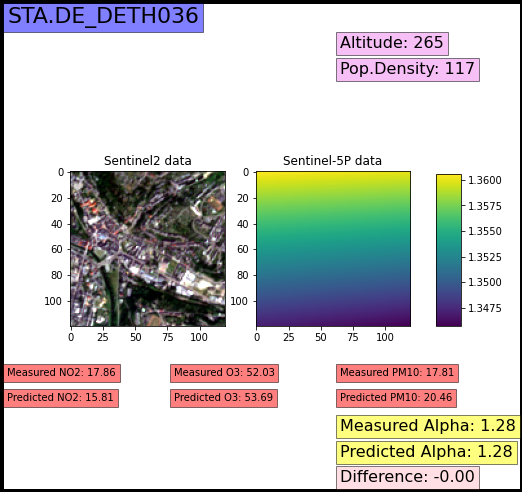

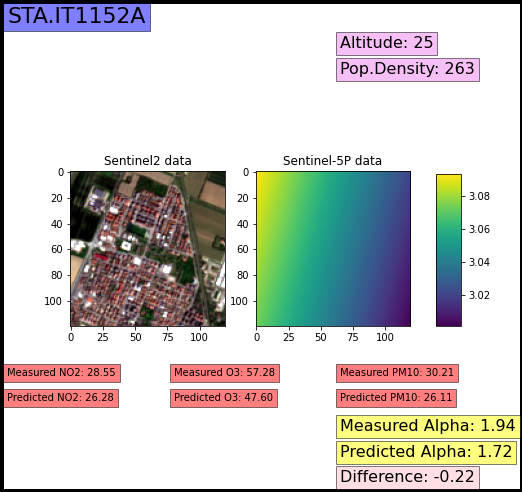

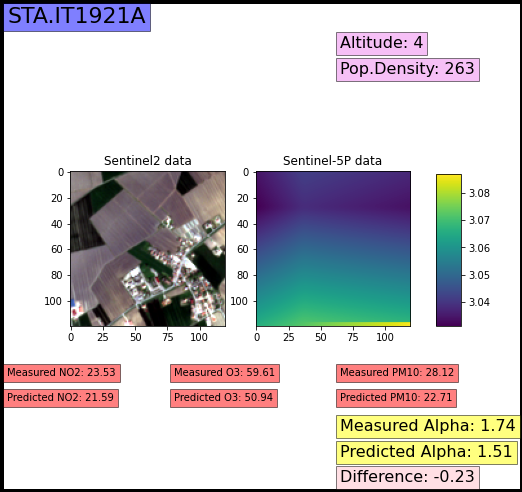

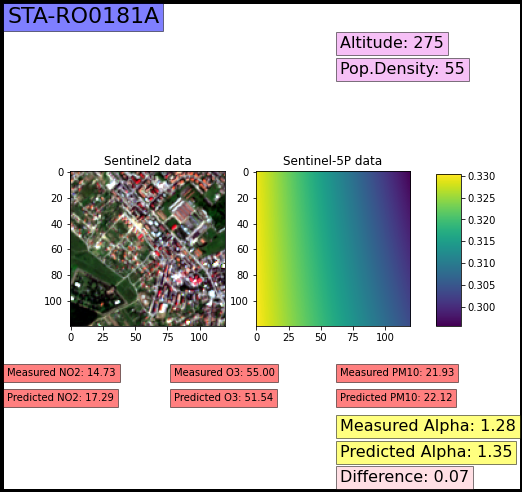

In [31]:
#warnings.filterwarnings('ignore')
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

#TEST THE OUTPUTS
#for i in [0,2,4]:
for i in tqdm(range(0,36),unit="station"):
    prediction_viewer(model_inspector(i,dataset_map,dataloader_map,model,device), also.iloc[i])

logger.setLevel(old_level)